## Access this Notebook
You can launch this notebook in the US GHG Center JupyterHub by clicking the link below. If you are a new user, you should first sign up for the hub by filling out this [**request form**](https://docs.google.com/forms/d/e/1FAIpQLSdai8otCdrVQzJgev8mjDhzKyCg7jcrB3UeTXNHoCiaMKrkaQ/viewform) and providing the required information. 


Access the [**MiCASA Land Carbon Flux**](https://us-ghg-center.github.io/ghgc-docs/user_data_notebooks/micasa-carbonflux-daygrid-v1_User_Notebook.html) notebook in the US GHG Center JupyterHub. 

## Table of Contents
- [Data Summary and Application](#data-summary-and-application)
- [Approach](#approach)
- [About the Data](#about-the-data)
- [Install the Required Libraries](#install-the-required-libraries)
- [Query the STAC API](#query-the-stac-api)
- [Visual Comparison Across Time Periods](#visual-comparison-across-time-periods)
- [Map Out Selected Tiles](#map-out-selected-tiles)
- [Calculate Zonal Statistics](#calculate-zonal-statistics)
- [Time-Series Analysis](#time-series-analysis)
- [Summary](#summary)

## Data Summary and Application
- **Spatial coverage**: Global
- **Spatial resolution**: 0.1° x 0.1°
- **Temporal extent**: January 1, 2001 - December 31, 2023
- **Temporal resolution**: Daily and Monthly Averages
- **Unit**: Grams of Carbon per square meter per day
- **Utility**: Climate Research

For more, visit the [MiCASA Land Carbon Flux](https://earth.gov/ghgcenter/data-catalog/micasa-carbonflux-grid-v1) data overview page.  

## Approach

1. Identify available dates and temporal frequency of observations for a given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the Land-Atmosphere Carbon Flux data product
2. Pass the STAC item into the raster API `/collections/{collection_id}/items/{item_id}/tilejson.json` endpoint
3. Using `folium.plugins.DualMap`, visualize two tiles (side-by-side), allowing time point comparison
4. After the visualization, perform zonal statistics for a given polygon

## About the Data
### MiCASA Land Carbon Flux
This dataset presents a variety of carbon flux parameters derived from the Más Informada Carnegie-Ames-Stanford-Approach (MiCASA) model. The model’s input data includes air temperature, precipitation, incident solar radiation, a soil classification map, and several satellite derived products. All model calculations are driven by analyzed meteorological data from NASA’s Modern-Era Retrospective analysis for Research and Application, Version 2 (MERRA-2). The resulting product provides global, daily data at 0.1 degree resolution from January 2001 through December 2023. It includes carbon flux variables expressed in units of kilograms of carbon per square meter per day (kg Carbon/m²/day) from net primary production (NPP), heterotrophic respiration (Rh), wildfire emissions (FIRE), fuel wood burning emissions (FUEL), net ecosystem exchange (NEE), and net biosphere exchange (NBE). The latter two are derived from the first four (see Scientific Details below). MiCASA is an extensive revision of the CASA – Global Fire Emissions Database, version 3 (CASA-GFED3) product. CASA-GFED3 and earlier versions of MERRA-driven CASA-GFED carbon fluxes have been used in several atmospheric carbon dioxide (CO₂) transport studies, serve as a community standard for priors of flux inversion systems, and through the support of NASA’s Carbon Monitoring System (CMS), help characterize, quantify, understand and predict the evolution of global carbon sources and sinks.

For more information regarding this dataset, please visit the [U.S. Greenhouse Gas Center](https://earth.gov/ghgcenter).

## Terminology
Navigating data via the GHGC API, you will encounter terminology that is different from browsing in a typical filesystem. We'll define some terms here which are used throughout this notebook.
- `catalog`:    All datasets available at the `/stac` endpoint
- `collection`: A specific dataset, e.g. MiCASA Land Carbon Flux
- `item`:       One granule in the dataset, e.g. one daily file of carbon fluxes
- `asset`:      A variable available within the granule, e.g. net primary productivity or net ecosystem exchange
- `STAC API`:   **Sp**atio**T**emporal **A**sset **C**atalogs - Endpoint for fetching metadata about available datasets
- `Raster API`: Endpoint for fetching data itself, for imagery and statistics

# Install the Required Libraries
Required libraries are pre-installed on the GHG Center Hub. If you need to run this notebook elsewhere, please install them with this line in a code cell:

%pip install requests folium rasterstats pystac_client pandas matplotlib --quiet

In [1]:
# Import the following libraries
# For fetching from the Raster API
import requests
# For making maps
import folium
import folium.plugins
from folium import Map, TileLayer
# For talking to the STAC API
from pystac_client import Client
# For working with data
import pandas as pd
# For making time series
import matplotlib.pyplot as plt
# For formatting date/time data
import datetime
# Custom functions for working with GHGC data via the API
import ghgc_utils

## Query the STAC API
### STAC API Collection Names

Now, you must fetch the dataset from the [**STAC API**](https://earth.gov/ghgcenter/api/stac/) by defining its associated STAC API collection ID as a variable. 
The collection ID, also known as the **collection name**, for theCarbonTracker-CH₄ Isotopic Methane Inverse Fluxes dataset is [**micasa-carbonflux-monthgrid-v1**](https://earth.gov/ghgcenter/api/stac/collections/micasa-carbonflux-monthgrid-v1).*

**You can find the collection name of any dataset on the GHGC data portal by navigating to the dataset landing page within the data catalog. The collection name is the last portion of the dataset landing page's URL, and is also listed in the pop-up box after clicking "ACCESS DATA."*

In [2]:
# Provide the STAC and RASTER API endpoints
# The endpoint is referring to a location within the API that executes a request on a data collection nesting on the server.

# The STAC API is a catalog of all the existing data collections that are stored in the GHG Center.
STAC_API_URL = "https://earth.gov/ghgcenter/api/stac"

# The RASTER API is used to fetch collections for visualization
RASTER_API_URL = "https://earth.gov/ghgcenter/api/raster"

# The collection name is used to fetch metadata from the STAC API.
collection_name = "micasa-carbonflux-monthgrid-v1"

In [3]:
# Fetch the collection from the STAC API using the appropriate endpoint
# The 'pystac_client' library allows a HTTP request possible
catalog = Client.open(STAC_API_URL)
collection = catalog.get_collection(collection_name)

# Print the properties of the collection to the console
collection

<CollectionClient id=micasa-carbonflux-monthgrid-v1>

Examining the contents of our `collection` under the `temporal` variable, we see that the data is available from January 2001 to December 2023. By looking at the `dashboard:time density`, we observe that the periodic frequency of these observations is monthly.

In [4]:
items = list(collection.get_items())  # Convert the iterator to a list
print(f"Found {len(items)} items")

KeyboardInterrupt: 

In [5]:
search = catalog.search(
    collections=collection_name,
    datetime=['2010-01-01T00:00:00Z','2010-12-31T00:00:00Z']
)
# Take a look at the items we found
for item in search.item_collection():
    print(item)

<Item id=micasa-carbonflux-monthgrid-v1-201012>
<Item id=micasa-carbonflux-monthgrid-v1-201011>
<Item id=micasa-carbonflux-monthgrid-v1-201010>
<Item id=micasa-carbonflux-monthgrid-v1-201009>
<Item id=micasa-carbonflux-monthgrid-v1-201008>
<Item id=micasa-carbonflux-monthgrid-v1-201007>
<Item id=micasa-carbonflux-monthgrid-v1-201006>
<Item id=micasa-carbonflux-monthgrid-v1-201005>
<Item id=micasa-carbonflux-monthgrid-v1-201004>
<Item id=micasa-carbonflux-monthgrid-v1-201003>
<Item id=micasa-carbonflux-monthgrid-v1-201002>
<Item id=micasa-carbonflux-monthgrid-v1-201001>


In [6]:
# Examine the first item in the collection
# Keep in mind that a list starts from 0, 1, 2... therefore items[0] is referring to the first item in the list/collection
items = search.item_collection() #CHANGETHIS
items[0]

<Item id=micasa-carbonflux-monthgrid-v1-201012>

In [7]:
# Restructure our items into a dictionary where keys are the datetime items
# Then we can query more easily by date/time, e.g. "2020-05"
items_dict = {item.properties["start_datetime"][:7]: item for item in items}

In [8]:
# Before we go further, let's pick which asset to focus on for the remainder of the notebook.
# We'll focus on net primary productivity, so our asset of interest is:
asset_name = "npp"

# Creating Maps Using Folium

You will now explore changes in the land atmosphere Carbon flux `Net Primary Productivity` at a given location. You will visualize the outputs on a map using `folium`.

## Fetch Imagery Using Raster API
Here we get information from the `Raster API` which we will add to our map in the next section.

In [9]:
# Specify two date/times that you would like to visualize, using the format of items_dict.keys()
dates = ["2010-01","2010-07"]

Below, we use some statistics of the raster data to set upper and lower limits for our color bar. These are saved as  `rescale_values`, and will be passed to the Raster API in the following step(s).

In [11]:
# Extract collection name and item ID for the first date
observation_date_1 = items_dict[dates[0]]
collection_id = observation_date_1.collection_id
item_id = observation_date_1.id
# Select relevant asset (NPP)
object = observation_date_1.assets[asset_name]
raster_bands = object.extra_fields.get("raster:bands", [{}])
# Print raster bands' information
raster_bands

[{'unit': 'g C m-2 day-1',
  'scale': 1.0,
  'nodata': 'nan',
  'offset': 0.0,
  'sampling': 'area',
  'data_type': 'float32',
  'histogram': {'max': 5.948176860809326,
   'min': -0.3724845349788666,
   'count': 11,
   'buckets': [488513, 9595, 5022, 3321, 2776, 3213, 4254, 4777, 2672, 145]},
  'statistics': {'mean': 0.1637769341468811,
   'stddev': 0.7254217411478966,
   'maximum': 5.948176860809326,
   'minimum': -0.3724845349788666,
   'valid_percent': 100.0}}]

In [12]:
# Use raster band statistics to generate an appropriate color bar range.
rescale_values = {
    "max": raster_bands[0].get("histogram", {}).get("max"),
    "min": raster_bands[0].get("histogram", {}).get("min"),
}

print(rescale_values)


{'max': 5.948176860809326, 'min': -0.3724845349788666}


Now, you will pass the `item id`, `collection name`, `asset name`, and the `rescale values` to the Raster API endpoint, along with a colormap. This step is done twice, one for each date/time you will visualize, and tells the Raster API which collection, item, and asset you want to view, specifying the colormap and colorbar ranges to use for visualization. The API returns a JSON with information about the requested image. Each image will be referred to as a tile.

In [13]:
# Choose a colormap for displaying the data
# Make sure to capitalize per Matplotlib standard colormap names
# For more information on Colormaps in Matplotlib, please visit https://matplotlib.org/stable/users/explain/colors/colormaps.html
color_map = "PuRd"

In [16]:
# Make a GET request to retrieve information for your first date/time
observation_date_1_tile = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id}/items/{item_id}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map.lower()}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}"
).json()

# Print the properties of the retrieved granule to the console
observation_date_1_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/micasa-carbonflux-monthgrid-v1/items/micasa-carbonflux-monthgrid-v1-201001/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=npp&color_formula=gamma+r+1.05&colormap_name=purd&rescale=-0.3724845349788666%2C5.948176860809326'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 179.99999999999994, 90.0],
 'center': [-2.842170943040401e-14, 0.0, 0]}

In [18]:
# Repeat the above for your second date/time
# Note that we do not calculate new rescale_values for this tile - 
# We want date tiles 1 and 2 to have the same colorbar range for visual comparison.
observation_date_2 = items_dict[dates[1]]
# Extract collection name and item ID
collection_id = observation_date_2.collection_id
item_id = observation_date_2.id
# Make a GET request to retrieve tile information
observation_date_2_tile = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id}/items/{item_id}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map.lower()}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}"
).json()

# Print the properties of the retrieved granule to the console
observation_date_2_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/micasa-carbonflux-monthgrid-v1/items/micasa-carbonflux-monthgrid-v1-201007/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=npp&color_formula=gamma+r+1.05&colormap_name=purd&rescale=-0.3724845349788666%2C5.948176860809326'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 179.99999999999994, 90.0],
 'center': [-2.842170943040401e-14, 0.0, 0]}

## Generate Map
For this example, we'll look at NPP over Amazon Rainforest, South America. 

First, let's determine an area of interest (AOI) to visualize via GeoJSON.

In [19]:
# Set a name for the AOI to use in plots later
aoi_name = "Amazon Rainforest"
# The Area of Interest (AOI) is set to Amazon Rainforest, South America
aoi = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "coordinates": [
            [
                # [longitude, latitude]
                [-74.0, -3.0],   # Southwest Bounding Coordinate
                [-74.0, 5.0],    # Southeast Bounding Coordinate
                [-60.0, 5.0],    # Northeast Bounding Coordinate
                [-60.0, -3.0],   # Northwest Bounding Coordinate
                [-74.0, -3.0]    # Closing the polygon at the Southwest Bounding Coordinate
            ]
        ],
        "type": "Polygon",
    },
}


In [30]:
# Initialize the map, specifying the center of the map and the starting zoom level.
# 'folium.plugins' allows mapping side-by-side via 'DualMap'
# Map is centered on the position specified by "location=(lat,lon)"
map_ = folium.plugins.DualMap(location=(0, -66), zoom_start=5)


# Define the first map layer using the tile fetched for the first date
# The TileLayer library helps in manipulating and displaying raster layers on a map
map_layer_observation_date_1 = TileLayer(
    tiles=observation_date_1_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution
    opacity=0.8, # Adjust the transparency of the layer
    name=f"{dates[0]} NPP", # Title for the layer
    overlay= True, # The layer can be overlaid on the map
    legendEnabled = True # Enable displaying the legend on the map
)

# Add the first layer to the Dual Map
# This will appear on the left side, specified by 'm1'
map_layer_observation_date_1.add_to(map_.m1)


# Define the second map layer using the tile fetched for the second date
map_layer_observation_date_2 = TileLayer(
    tiles=observation_date_2_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution
    opacity=0.8, # Adjust the transparency of the layer
    name=f"{dates[1]} NPP", # Title for the layer
    overlay= True, # The layer can be overlaid on the map
    legendEnabled = True # Enable displaying the legend on the map
)

# Add the second layer to the Dual Map
# This will appear on the left side, specified by 'm2'
map_layer_observation_date_2.add_to(map_.m2)

# Display data marker on each map
folium.Marker((0, -66), tooltip=aoi_name).add_to(map_)
# Display AOI on each map
folium.GeoJson(aoi, name=f"{aoi_name} AOI",style_function=lambda feature: {"fillColor": "none"}).add_to(map_)
# Add a layer control to switch between map layers
folium.LayerControl(collapsed=False).add_to(map_)

# Add colorbar
# We can use 'generate_html_colorbar' from the 'ghgc_utils' module 
# to create an HTML colorbar representation.
legend_html = ghgc_utils.generate_html_colorbar(color_map,rescale_values,label='NPP (g Carbon/m2/daily)',dark=True)

# Add colorbar to the map
map_.get_root().html.add_child(folium.Element(legend_html))

# Visualize the Dual Map
map_

# Calculate Zonal Statistics
To perform zonal statistics, first we need to create a polygon. In this use case we are creating a polygon in the Amazon Rainforest.

In [19]:
# Set a name for the AOI to use in plots later
aoi_name = "Amazon Rainforest"
# The Area of Interest (AOI) is set to Amazon Rainforest, South America
aoi = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "coordinates": [
            [
                # [longitude, latitude]
                [-74.0, -3.0],   # Southwest Bounding Coordinate
                [-74.0, 5.0],    # Southeast Bounding Coordinate
                [-60.0, 5.0],    # Northeast Bounding Coordinate
                [-60.0, -3.0],   # Northwest Bounding Coordinate
                [-74.0, -3.0]    # Closing the polygon at the Southwest Bounding Coordinate
            ]
        ],
        "type": "Polygon",
    },
}


We'll generate statistics for the data in our AOI using a function from the `ghgc_utils` module, which fetches the data and its statistics from the Raster API.

In [32]:
%%time
# %%time = Wall time (execution time) for running the code below

# Statistics will be returned as a Pandas DataFrame
df = ghgc_utils.generate_stats(items,aoi,url=RASTER_API_URL,asset=asset_name)
# Print the first five rows of statistics from our DataFrame
df.head(5)

Generating stats...
Done!
CPU times: user 24.5 ms, sys: 15.6 ms, total: 40.1 ms
Wall time: 1.41 s


,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2010-12-01T00:00:00+00:00,0.00000000000000000000,4.89262914657592773438,4.21476554870605468750,11200.00000000000000000000,47205.37500000000000000000,0.67433501265570172656,4.46684360504150390625,0.00000000000000000000,0.09475493431091308594,11151.00000000000000000000,"[[17, 11, 43, 129, 196, 517, 399, 617, 2585, 6...",100.00000000000000000000,0.00000000000000000000,11200.00000000000000000000,2.06423521041870117188,4.74646377563476562500,2010-12-01 00:00:00+00:00
1,2010-11-01T00:00:00+00:00,0.00000000000000000000,4.99066686630249023438,4.32144927978515625000,11200.00000000000000000000,48400.23437500000000000000,0.67623451775757548177,4.56732463836669921875,0.00000000000000000000,0.11350738257169723511,11152.00000000000000000000,"[[21, 13, 38, 124, 154, 462, 442, 634, 2499, 6...",100.00000000000000000000,0.00000000000000000000,11200.00000000000000000000,2.11893200874328613281,4.85591602325439453125,2010-11-01 00:00:00+00:00
2,2010-10-01T00:00:00+00:00,0.00000000000000000000,5.11889410018920898438,4.37894201278686523438,11200.00000000000000000000,49044.14843750000000000000,0.70461959934651896553,4.64984226226806640625,0.00000000000000000000,0.00312864035367965698,11153.00000000000000000000,"[[21, 14, 48, 137, 155, 492, 540, 620, 2731, 6...",100.00000000000000000000,0.00000000000000000000,11200.00000000000000000000,2.05418276786804199219,4.93095159530639648438,2010-10-01 00:00:00+00:00
3,2010-09-01T00:00:00+00:00,0.00000000000000000000,5.20381402969360351562,4.25992536544799804688,11200.00000000000000000000,47711.16406250000000000000,0.64925810583296306167,4.48059511184692382812,0.00000000000000000000,0.07202455401420593262,11170.00000000000000000000,"[[18, 13, 42, 135, 184, 544, 540, 827, 7751, 1...",100.00000000000000000000,0.00000000000000000000,11200.00000000000000000000,2.13949847221374511719,4.92846536636352539062,2010-09-01 00:00:00+00:00
4,2010-08-01T00:00:00+00:00,0.00000000000000000000,5.27340316772460937500,4.15344095230102539062,11200.00000000000000000000,46518.53906250000000000000,0.59038417891895100809,4.29437303543090820312,0.00000000000000000000,0.00740983802825212479,11165.00000000000000000000,"[[15, 13, 39, 106, 164, 576, 668, 2322, 6589, ...",100.00000000000000000000,0.00000000000000000000,11200.00000000000000000000,2.30402040481567382812,4.91697549819946289062,2010-08-01 00:00:00+00:00


## Time-Series Analysis
You can now explore the net primary production values using this data collection (January 2021 -December 2023) for the Amazon Rainforest, South America region. You can plot the data set using the code below:

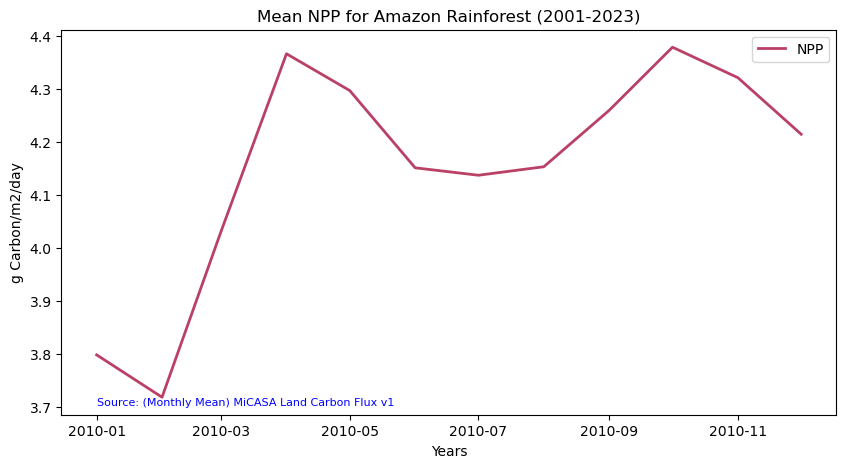

In [50]:
# Determine the width and height of the plot using the 'matplotlib' library
# Figure size: 20 representing the width, 10 representing the height
fig = plt.figure(figsize=(10, 5)) 

# Change 'which_stat' below if you would rather look at a different statistic, like minimum or mean.
which_stat = "mean"

# Plot the time series analysis of the daily NPP Values for Amazon Rainforest, South America
plt.plot(
    df["date"], # X-axis: date
    df[which_stat], # Y-axis: NPP value
    color="#BA4066", # Line color in hex format
    linestyle="-", # Line style
    linewidth=2, # Line width
    label=asset_name.upper(), # Legend label
)

# Display legend
plt.legend()

# Insert label for the X-axis
plt.xlabel("Years")

# Insert label for the Y-axis
plt.ylabel("g Carbon/m2/day")

# Insert title for the plot
plt.title(f"{which_stat.capitalize()} {asset_name.upper()} for {aoi_name} (2001-2023)")

# Add data citation
plt.text(
    df["date"].iloc[-1],           # X-coordinate of the text
    df[which_stat].min(),                  # Y-coordinate of the text

    # Text to be displayed
    f"Source: {collection.title}",                  
    fontsize=8,                             # Font size
    horizontalalignment="left",              # Horizontal alignment
    verticalalignment="top",                 # Vertical alignment
    color="blue",                            # Text color
)

plt.show()

## Summary

In this notebook we have successfully completed the following steps for the STAC collection for the MiCASA Land Carbon Flux dataset:
1.	Install and import the necessary libraries 
2.	Fetch the collection from STAC collections using the appropriate endpoints
3.	Count the number of existing granules within the collection
4.	Map and compare the Net Primary Production (NPP) levels over the Amazon Rainforest, South America area for two distinctive months/years
5.	Create a table that displays the minimum, maximum, and sum of the Net Primary Production (NPP) values for a specified region
6.	Generate a time-series graph of the Net Primary Production (NPP) values for a specified region

If you have any questions regarding this user notebook, please contact us using the [feedback form](https://docs.google.com/forms/d/e/1FAIpQLSeVWCrnca08Gt_qoWYjTo6gnj1BEGL4NCUC9VEiQnXA02gzVQ/viewform). 